In [10]:
import numpy as np

def np_relu(x):
    
    return np.maximum(0,x)


def initialize_Z(W, X):
    
    W_t = np.transpose(W)
    lmda = 0.1
    inverse_term = np.linalg.inv(np.eye(W.shape[1]) + (lmda ** -1) * np.matmul(W_t,W))
    woodbury = (lmda ** -1) * np.eye(W.shape[0]) - np.matmul((lmda ** -2) * W , np.matmul(inverse_term, W_t))
    Z = np_relu(np.matmul(np.matmul(woodbury, W), X.T))
    
    return Z


def maximize_function(w, z, x):
    
    mean = np.matmul(z.T, w)
    mean = 1e-10 + np_relu(mean)
    negative_log_likelihood = (- mean + np.multiply(x, np.log(mean))).sum()

    return negative_log_likelihood


def calc_aic(w, z, x):

    mean = np.matmul(z.T, w)
    mean = 1e-10 + np_relu(mean)
    log_likelihood = (- mean + np.multiply(x, np.log(mean))).sum()
    AIC = log_likelihood - np.count_nonzero(np_relu(w) > 1e-05) - np.count_nonzero(np_relu(z) > 1e-05)
    
    return AIC


""" Multiplicative Updates """

def multiplicative_updates(W, Z, X, n, method):
    
    lw = 0.0
    lz = 0.8
    beta = 0.5
    convergence_criteria = np.exp(-15)
    epsilon_reg = 1e-08
    loss_values = []

    if method == 0:
        for i in range(n):
            print(i)
            mean = np.matmul(Z.T, W)
            mean = 1e-10 + np_relu(mean)
            X_by_mean = X / mean
            
            W = np.multiply(W, np_relu(np.matmul(Z, X_by_mean)))
            W = W / np.array([W.sum(axis = 1)]).T
            Z = np.multiply(Z, np_relu(np.matmul(W, X_by_mean.T)))

            LL = maximize_function(W, Z, X)
            print(LL, i, flush=True)
            loss_values.append(LL)
            
            if len(loss_values) >= 10 :
                
                if ((loss_values[i] - loss_values[i-10]) / loss_values[i]) < convergence_criteria:
                    AIC = calc_aic(W, Z, X)
                    print("Function is converged")
                    break
                else:
                    raise RuntimeError(f'function not converged') 
        print(AIC, "within method mul update")
    
        return  Z, loss_values, AIC
    
    raise ValueError(f'method must be 0, 1, 2, got {method}')


In [11]:
import pandas as pd
import numpy as np
import bin_assignments as assign
import nmf_connected_components_modified as nmf
def assign_shortcontigs(working_dir, sel_inds, Rc_reads, contigs, bins_):
    contig_names = contigs[:,1]
    contig_length = contigs[:,2].astype(int)
    fractional_counts = pd.read_csv(working_dir + "total_readcount", header=None,sep=' ', engine="pyarrow")
    read_counts = fractional_counts.pivot_table(index = 1, columns = 0, values = 2)
    del(fractional_counts)

    read_counts = read_counts.to_numpy().T
    read_counts_sel =  read_counts[sel_inds]

    read_counts_n = np.delete(read_counts, sel_inds, axis=0)
    del(read_counts)

    bins_ = bins_.T

    Rc_reads_bins = Rc_reads[bins_[:,0]]

    if np.min(Rc_reads_bins) == 0:
        
        bins_withRc = np.column_stack((bins_, Rc_reads_bins.T)).astype(int)
        bins_withRc = pd.DataFrame(bins_withRc)
        bins_withRc.columns = ['ind','bin','Rc']
        bin_selectedinds = bins_withRc.loc[bins_withRc.groupby('bin').Rc.idxmax()]['ind']

        W_bins = read_counts_sel[bin_selectedinds] / read_counts_sel[bin_selectedinds].sum(axis=1, keepdims=True)
        
        Z = initialize_Z(W_bins, read_counts_n)

        contig_length_n =np.delete(contig_length, sel_inds)
        contig_names_n = np.delete(contig_names, sel_inds)
        contig_names = contig_names[sel_inds]

        Z_parts = np.array_split(Z, 10, axis=1)
        read_counts_npart = np.array_split(read_counts_n, 10, axis=0)
        Z_optimized = []
        AIC_values = []
        
        for f in range(10):
            Z_opt, AIC = nmf.multiplicative_updates(W_bins, Z_parts[f], read_counts_npart[f], 1000, 0)
            Z_optimized.append(Z_opt)
            AIC_values.append(AIC)

        Z_optimized = np.concatenate(Z_optimized, axis=1)
        bin_assign, bin_m_assign = assign.assignment(Z_optimized, contig_length_n, 0)
        initial_bins = np.stack((contig_names[bins_[0]], bins_[1])).T
        short_addedbins = np.stack((contig_names_n[bin_assign[0]], bin_assign[1])).T
        total_bins = np.vstack([initial_bins, short_addedbins])

        return total_bins

    else:
        
        raise RuntimeError("some contigs may have zero total count. Filter them before processing")

/big/work/metadevol/cami2_datasets/marine/pooled_assembly/all_alignment/tmp/


In [12]:
Z_opt, loss_values, AIC = multiplicative_updates(W_bins, Z, read_counts_n, 1000, 0)

0


KeyboardInterrupt: 

In [34]:
np.shape(np.vstack([bins_,bins_]))

(241414, 2)

In [ ]:
multiplicative_updates(W_bins, Z_parts[1], read_counts_n[1], 1000, 0)

NameError: name 'W_bins' is not defined

In [35]:
np.shape(bins_)

(120707, 2)

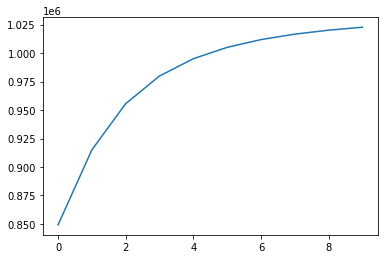

In [24]:
import matplotlib.pyplot as plt 

plt.plot(LL[1])

In [ ]:
np.argmax(contig_length_n[(np.where(Rc_reads_n==0))])
contig_length_n = np.delete(contig_length_n, np.where(Rc_reads_n==0)[0])
contig_names_n = np.delete(contig_names_n, np.where(Rc_reads_n==0)[0])
read_counts_n = np.delete(read_counts, sel_ind, axis=0)
read_counts_n = np.delete(read_counts_n, np.where(Rc_reads_n==0)[0], axis=0)
Z = initialize_Z(W_bins, read_counts_n)

In [ ]:
Z_opt, loss_values, AIC = multiplicative_updates(W_bins, Z, read_counts_n, 1000, 0)

0
9108744.970415434 0
1
9875817.518626403 1
2
10348163.031736145 2
3
10628758.927983038 3
4
10801734.376173705 4
5
10913605.639439274 5
6
10988867.597564237 6
7
11041084.926887581 7
8
11078238.926847832 8
9
11105257.761477567 9
Function is converged
-403473174.2385224 within method mul update


In [ ]:
import bin_assignments as assign

bin_assign, bin_m_assign = assign.assignment(Z_opt, contig_length_n, 0)

/big/work/metadevol/scripts/bin_assignments.py:17: RuntimeWarning: invalid value encountered in divide
  weights = Z_bc ** 5 / Rc ** 4


In [ ]:
len(read_counts_n)

585259

In [ ]:
# argmax = np.argmax(Z_opt, axis=0)

# """ Assignment """
Z_assign = Z_opt
Rc_c  = np.sum(Z_assign, axis=0)
pb_c  = Z_assign / Rc_c
cov_b = np.sum(Z_assign, axis=1) / np.sum((np.array(contig_length_n) * Z_assign) / Rc_c, axis=1)
pb_min = 0.8 * (cov_b.reshape(len(cov_b),1) * np.sum(np.square(pb_c), axis=0) \
                / np.sum(cov_b.reshape(len(cov_b),1) * pb_c, axis=0))
pb_min[pb_min > 0.5] = 0.5
contig_assign0 = np.argmax(pb_c/pb_min, axis=0)

print(len(set(contig_assign0)), "number of bins")
print(len(set(np.argmax(Z_assign, axis=0))), "just max")

87 number of bins
197 just max


In [ ]:
import bin_assignments as assign
# bins_, bins_m = assign.assignment(Z_opt, contig_length_n, 0)
bins_1, bins_m1 = assign.assignment(Z_opt, contig_length_n, 1)

0 length of selected_inds
[ 2524.92373532  2491.88181018  6076.85362016 ...  9461.07770518
 15007.08959204 11486.08551772]


In [ ]:
np.savetxt(working_dir + "/bin_assignments_shortcontigs_single", np.stack((contig_names_n, bin_assign)).T, fmt='%s\t%d')

In [ ]:
np.savetxt(working_dir + "try/length_2500/bin_assignments_shortcontigs_multi", np.vstack((contig_names_n[bin_m_assign[1]], bin_m_assign[0])).T, fmt='%s\t%d')

In [ ]:
np.savetxt(working_dir + "try/length_2500/bin_assignments_shortcontigs_argmax", np.vstack((contig_names_n, argmax)).T, fmt='%s\t%d')

In [ ]:
np.savetxt(working_dir + "/bin_assignments_shortcontigs_single", np.stack((contig_names_n, bins_)).T, fmt='%s\t%d')

In [ ]:
bins_1

array([1641, 1425, 1499, ..., 1008, 1672, 1446])

In [ ]:
bins_

array([439, 635, 804, ..., 202,  78, 299])

In [ ]:
bins_1

array([1641, 1425, 1499, ..., 1008, 1672, 1446])

In [ ]:
np.savetxt(working_dir + "/bin_assignments_shortcontigs_single1", np.stack((contig_names_n, bins_1)).T, fmt='%s\t%d')